# 文本分类_谷歌机器学习指南对应的代码

1. [文本分类_谷歌机器学习指南 中文](https://yuanxiaosc.github.io/2019/06/11/%E6%96%87%E6%9C%AC%E5%88%86%E7%B1%BB_%E8%B0%B7%E6%AD%8C%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0%E6%8C%87%E5%8D%97/)
2. [文本分类_谷歌机器学习指南 英文](https://developers.google.com/machine-learning/guides/text-classification/)
3. [text_classification GitHub Code](https://github.com/google/eng-edu/tree/master/ml/guides/text_classification)

## 1. 搜集数据

Download and decompress data http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

In [1]:
!wget https://github.com/google/eng-edu/raw/master/ml/guides/text_classification/load_data.py

--2019-06-11 15:59:12--  https://github.com/google/eng-edu/raw/master/ml/guides/text_classification/load_data.py
Resolving github.com (github.com)... 52.74.223.119
Connecting to github.com (github.com)|52.74.223.119|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/google/eng-edu/master/ml/guides/text_classification/load_data.py [following]
--2019-06-11 15:59:13--  https://raw.githubusercontent.com/google/eng-edu/master/ml/guides/text_classification/load_data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.76.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.76.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8538 (8.3K) [text/plain]
Saving to: ‘load_data.py’

load_data.py        100%[===================>]   8.34K  --.-KB/s    in 0s      

2019-06-11 15:59:15 (97.5 MB/s) - ‘load_data.py’ saved [8538/8538]



In [2]:
import os
import random

import numpy as np
import pandas as pd

In [3]:
def load_imdb_sentiment_analysis_dataset(data_path, seed=123):
    """Loads the Imdb movie reviews sentiment analysis dataset.
    # Arguments
        data_path: string, path to the data directory.
        seed: int, seed for randomizer.
    # Returns
        A tuple of training and validation data.
        Number of training samples: 25000
        Number of test samples: 25000
        Number of categories: 2 (0 - negative, 1 - positive)
    # References
        Mass et al., http://www.aclweb.org/anthology/P11-1015
        Download and uncompress archive from:
        http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    """
    imdb_data_path = os.path.join(data_path, 'aclImdb')

    # Load the training data
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname)) as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)

    # Load the validation data.
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname)) as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)

    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((train_texts, np.array(train_labels)),
            (test_texts, np.array(test_labels)))

In [5]:
(train_texts, train_labels), (test_texts, test_labels) = load_imdb_sentiment_analysis_dataset(data_path=".")

## 2. 探索数据

In [7]:
train_texts[0]

"POSSIBLE SPOILERS<br /><br />The Spy Who Shagged Me is a muchly overrated and over-hyped sequel. International Man of Mystery came straight out of the blue. It was a lone star that few people had heard of. But it was stunningly original, had sophisticated humour and ample humour, always kept in good taste, and had a brilliant cast. The Spy Who Shagged Me was a lot more commercially advertised and hyped about.<br /><br />OK I'll admit, the first time I saw this film I thought it was very funny, but it's only after watching it two or three times that you see all the flaws. The acting was OK, but Heather Graham cannot act. Her performance didn't seem very convincing and she wasn't near as good as Liz Hurley was in the first one. Those characters who bloomed in the first one, (Scott Evil, Number 2 etc.) are thrown into the background hear and don't get many stand-alone scenes. The film is simply overrun with cameos.<br /><br />In particular, I hated the way they totally disregarded some o

In [8]:
len(train_texts)

25000

In [9]:
!wget https://github.com/google/eng-edu/raw/master/ml/guides/text_classification/explore_data.py

--2019-06-11 16:09:34--  https://github.com/google/eng-edu/raw/master/ml/guides/text_classification/explore_data.py
Resolving github.com (github.com)... 13.250.177.223
Connecting to github.com (github.com)|13.250.177.223|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/google/eng-edu/master/ml/guides/text_classification/explore_data.py [following]
--2019-06-11 16:09:35--  https://raw.githubusercontent.com/google/eng-edu/master/ml/guides/text_classification/explore_data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.76.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.76.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4908 (4.8K) [text/plain]
Saving to: ‘explore_data.py’

explore_data.py     100%[===================>]   4.79K  --.-KB/s    in 0s      

2019-06-11 16:09:37 (76.7 MB/s) - ‘explore_data.py’ saved [4908/4908]



In [10]:
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
def get_num_classes(labels):
    """Gets the total number of classes.
    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    # Returns
        int, total number of classes.
    # Raises
        ValueError: if any label value in the range(0, num_classes - 1)
            is missing or if number of classes is <= 1.
    """
    num_classes = max(labels) + 1
    missing_classes = [i for i in range(num_classes) if i not in labels]
    if len(missing_classes):
        raise ValueError('Missing samples with label value(s) '
                         '{missing_classes}. Please make sure you have '
                         'at least one sample for every label value '
                         'in the range(0, {max_class})'.format(
                            missing_classes=missing_classes,
                            max_class=num_classes - 1))

    if num_classes <= 1:
        raise ValueError('Invalid number of labels: {num_classes}.'
                         'Please make sure there are at least two classes '
                         'of samples'.format(num_classes=num_classes))
    return num_classes

In [12]:
get_num_classes(train_labels)

2

In [13]:
def get_num_words_per_sample(sample_texts):
    """Gets the median number of words per sample given corpus.
    # Arguments
        sample_texts: list, sample texts.
    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

In [14]:
get_num_words_per_sample(train_texts)

174.0

In [19]:
def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 2),
                                          num_ngrams=50):
    """Plots the frequency distribution of n-grams.
    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.savefig("Frequency distribution of n-grams.png")
    plt.show()

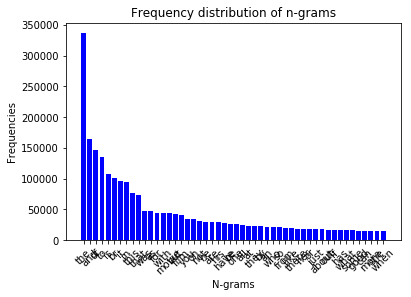

In [20]:
plot_frequency_distribution_of_ngrams(train_texts)

In [21]:
def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.
    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.savefig("Sample length distribution.png")
    plt.show()

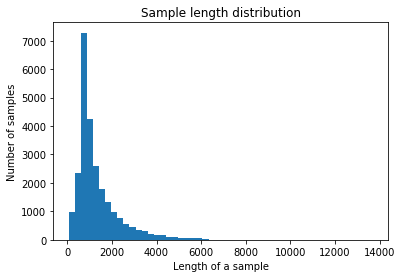

In [23]:
plot_sample_length_distribution(train_texts)

## 3. 准备数据

In [24]:
!wget https://github.com/google/eng-edu/raw/master/ml/guides/text_classification/vectorize_data.py

--2019-06-11 16:29:34--  https://github.com/google/eng-edu/raw/master/ml/guides/text_classification/vectorize_data.py
Resolving github.com (github.com)... 13.229.188.59
Connecting to github.com (github.com)|13.229.188.59|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/google/eng-edu/master/ml/guides/text_classification/vectorize_data.py [following]
--2019-06-11 16:29:35--  https://raw.githubusercontent.com/google/eng-edu/master/ml/guides/text_classification/vectorize_data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.76.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.76.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3645 (3.6K) [text/plain]
Saving to: ‘vectorize_data.py’

vectorize_data.py   100%[===================>]   3.56K  --.-KB/s    in 0s      

2019-06-11 16:29:36 (66.4 MB/s) - ‘vectorize_data.py’ saved [3645/3645]



In [25]:
import tensorflow as tf
import numpy as np

from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [26]:
# Vectorization parameters

# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500

In [27]:
def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as ngram vectors.
    1 text = 1 tf-idf vector the length of vocabulary of uni-grams + bi-grams.
    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.
    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train)
    x_val = selector.transform(x_val)

    x_train = x_train.astype('float32')
    x_val = x_val.astype('float32')
    return x_train, x_val

In [29]:
x_train, x_test = ngram_vectorize(train_texts, train_labels, test_texts)

In [30]:
x_train.shape

(25000, 20000)

In [31]:
def sequence_vectorize(train_texts, val_texts):
    """Vectorizes texts as sequence vectors.
    1 text = 1 sequence vector with fixed length.
    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.
    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer.word_index

In [32]:
x_train_seq, x_test_seq, tokenizer_word_index_seq = sequence_vectorize(train_texts, test_texts)

In [33]:
x_train_seq.shape

(25000, 500)

## 4. 构建，训练和评估模型

In [48]:
!wget https://github.com/google/eng-edu/raw/master/ml/guides/text_classification/build_model.py

--2019-06-11 17:06:54--  https://github.com/google/eng-edu/raw/master/ml/guides/text_classification/build_model.py
Resolving github.com (github.com)... 52.74.223.119
Connecting to github.com (github.com)|52.74.223.119|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/google/eng-edu/master/ml/guides/text_classification/build_model.py [following]
--2019-06-11 17:06:55--  https://raw.githubusercontent.com/google/eng-edu/master/ml/guides/text_classification/build_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.76.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.76.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5946 (5.8K) [text/plain]
Saving to: ‘build_model.py’

build_model.py      100%[===================>]   5.81K  --.-KB/s    in 0s      

2019-06-11 17:06:56 (85.6 MB/s) - ‘build_model.py’ saved [5946/5946]



In [35]:
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D

In [36]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.
    # Arguments
        num_classes: int, number of classes.
    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [37]:
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.
    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
    # Returns
        An MLP model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model

In [38]:
mlp_model_instance = mlp_model(layers=3, units=8, dropout_rate=0.2, input_shape=(20000,), num_classes=2)

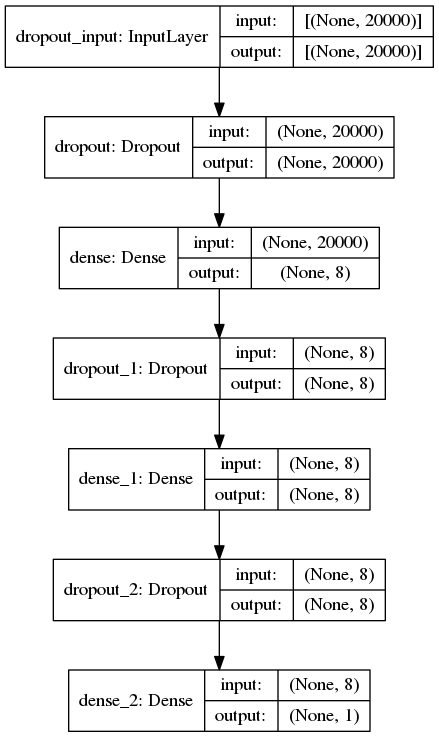

In [39]:
tf.keras.utils.plot_model(mlp_model_instance, show_shapes=True)

In [40]:
def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_classes,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
    """Creates an instance of a separable CNN model.
    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.
    # Returns
        A sepCNN model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    return model

In [44]:
sepcnn_model_instance = sepcnn_model(blocks=3, filters=8, kernel_size=3, embedding_dim=50, dropout_rate=0.2,
                                     pool_size=2, input_shape=(20000, 500), num_classes=2, num_features=500)

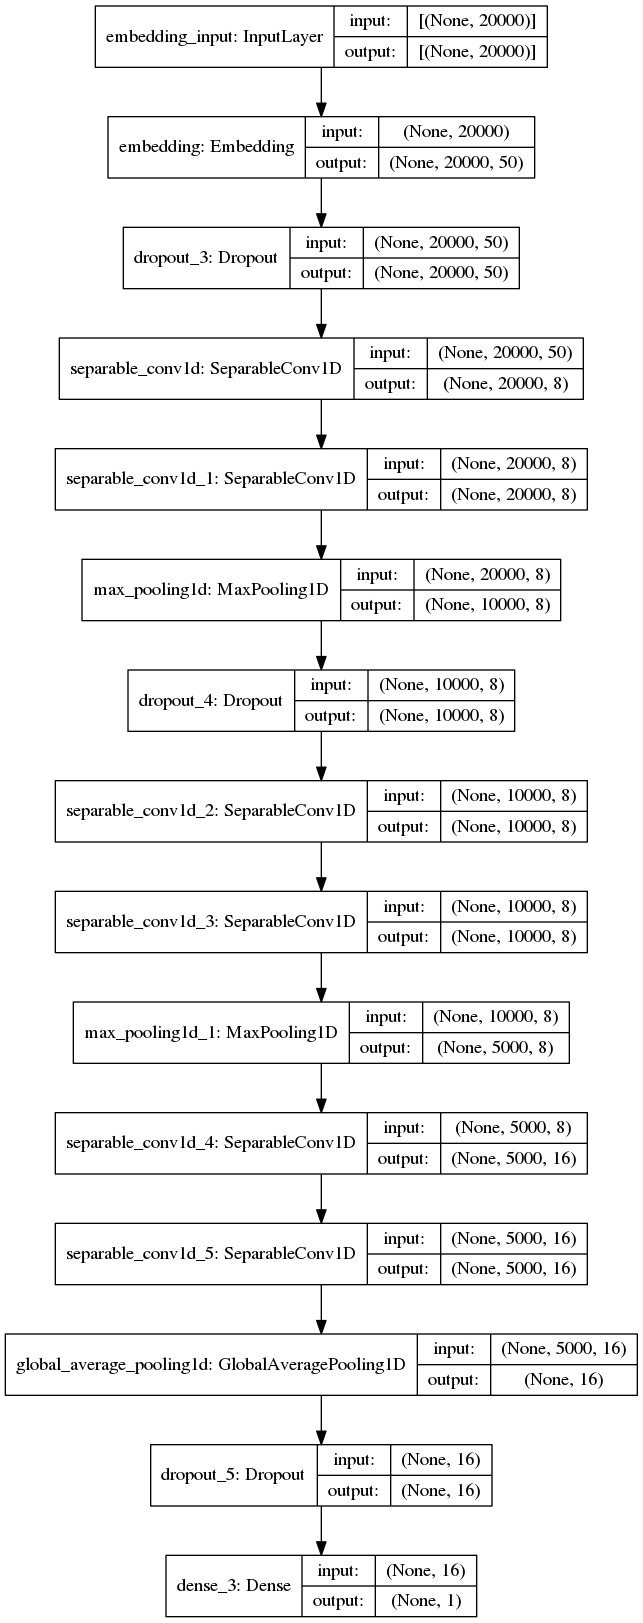

In [45]:
tf.keras.utils.plot_model(sepcnn_model_instance, show_shapes=True)

In [60]:
!wget https://github.com/google/eng-edu/raw/master/ml/guides/text_classification/train_ngram_model.py

--2019-06-11 17:22:23--  https://github.com/google/eng-edu/raw/master/ml/guides/text_classification/train_ngram_model.py
Resolving github.com (github.com)... 13.250.177.223
Connecting to github.com (github.com)|13.250.177.223|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/google/eng-edu/master/ml/guides/text_classification/train_ngram_model.py [following]
--2019-06-11 17:22:24--  https://raw.githubusercontent.com/google/eng-edu/master/ml/guides/text_classification/train_ngram_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.76.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.76.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4136 (4.0K) [text/plain]
Saving to: ‘train_ngram_model.py’

train_ngram_model.p 100%[===================>]   4.04K  --.-KB/s    in 0s      

2019-06-11 17:22:26 (85.1 MB/s) - ‘train_ngram_model.py’ saved [

In [49]:
import argparse
import time

import tensorflow as tf
import numpy as np

import build_model
import load_data
import vectorize_data
import explore_data

FLAGS = None


def train_ngram_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2):
    """Trains n-gram model on the given dataset.
    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.
    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
    num_classes = explore_data.get_num_classes(train_labels)
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the '
                         'labels in the validation set are in the same range '
                         'as training labels.'.format(
                             unexpected_labels=unexpected_labels))

    # Vectorize texts.
    x_train, x_val = vectorize_data.ngram_vectorize(
        train_texts, train_labels, val_texts)

    # Create model instance.
    model = build_model.mlp_model(layers=layers,
                                  units=units,
                                  dropout_rate=dropout_rate,
                                  input_shape=x_train.shape[1:],
                                  num_classes=num_classes)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('imdb_mlp_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1]

In [51]:
# Using the IMDb movie reviews dataset to demonstrate training n-gram model
data = load_data.load_imdb_sentiment_analysis_dataset(".")
train_ngram_model(data)

W0611 17:09:13.598596 140119362250496 deprecation.py:323] From /home/b418/anaconda3/envs/yuanxiao/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1251: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 25000 samples, validate on 25000 samples
Epoch 1/1000
25000/25000 - 6s - loss: 0.4727 - acc: 0.8610 - val_loss: 0.3234 - val_acc: 0.8872
Epoch 2/1000
25000/25000 - 5s - loss: 0.2330 - acc: 0.9209 - val_loss: 0.2509 - val_acc: 0.9020
Epoch 3/1000
25000/25000 - 6s - loss: 0.1681 - acc: 0.9416 - val_loss: 0.2351 - val_acc: 0.9059
Epoch 4/1000
25000/25000 - 5s - loss: 0.1350 - acc: 0.9536 - val_loss: 0.2327 - val_acc: 0.9052
Epoch 5/1000
25000/25000 - 5s - loss: 0.1105 - acc: 0.9645 - val_loss: 0.2324 - val_acc: 0.9046
Epoch 6/1000
25000/25000 - 5s - loss: 0.0934 - acc: 0.9705 - val_loss: 0.2389 - val_acc: 0.9036
Epoch 7/1000
25000/25000 - 5s - loss: 0.0796 - acc: 0.9746 - val_loss: 0.2476 - val_acc: 0.9012
Validation accuracy: 0.9012399911880493, loss: 0.24761022700309754


(0.90124, 0.24761022700309754)

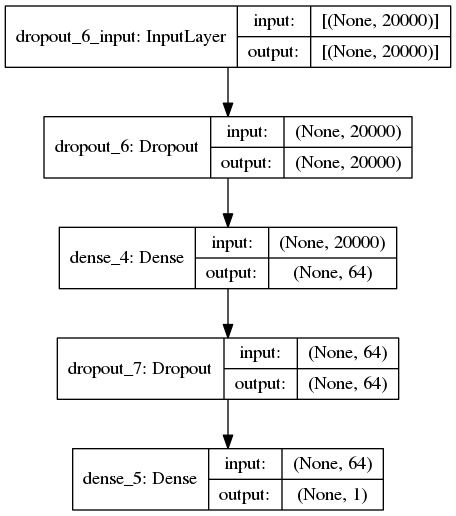

In [58]:
imdb_mlp_model = tf.keras.models.load_model("imdb_mlp_model.h5")

tf.keras.utils.plot_model(imdb_mlp_model, show_shapes=True)

In [52]:
!wget https://github.com/google/eng-edu/raw/master/ml/guides/text_classification/train_sequence_model.py

--2019-06-11 17:10:21--  https://github.com/google/eng-edu/raw/master/ml/guides/text_classification/train_sequence_model.py
Resolving github.com (github.com)... 13.250.177.223
Connecting to github.com (github.com)|13.250.177.223|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/google/eng-edu/master/ml/guides/text_classification/train_sequence_model.py [following]
--2019-06-11 17:10:22--  https://raw.githubusercontent.com/google/eng-edu/master/ml/guides/text_classification/train_sequence_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.76.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.76.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5062 (4.9K) [text/plain]
Saving to: ‘train_sequence_model.py’

train_sequence_mode 100%[===================>]   4.94K  --.-KB/s    in 0s      

2019-06-11 17:10:23 (80.2 MB/s) - ‘train_sequence_mo

In [53]:
import argparse
import time

import tensorflow as tf
import numpy as np

import build_model
import load_data
import vectorize_data
import explore_data

FLAGS = None

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000


def train_sequence_model(data,
                         learning_rate=1e-3,
                         epochs=1000,
                         batch_size=128,
                         blocks=2,
                         filters=64,
                         dropout_rate=0.2,
                         embedding_dim=200,
                         kernel_size=3,
                         pool_size=3):
    """Trains sequence model on the given dataset.
    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of sepCNN layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.
        embedding_dim: int, dimension of the embedding vectors.
        kernel_size: int, length of the convolution window.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
    num_classes = explore_data.get_num_classes(train_labels)
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the '
                         'labels in the validation set are in the same range '
                         'as training labels.'.format(
                             unexpected_labels=unexpected_labels))

    # Vectorize texts.
    x_train, x_val, word_index = vectorize_data.sequence_vectorize(
            train_texts, val_texts)

    # Number of features will be the embedding input dimension. Add 1 for the
    # reserved index 0.
    num_features = min(len(word_index) + 1, TOP_K)

    # Create model instance.
    model = build_model.sepcnn_model(blocks=blocks,
                                     filters=filters,
                                     kernel_size=kernel_size,
                                     embedding_dim=embedding_dim,
                                     dropout_rate=dropout_rate,
                                     pool_size=pool_size,
                                     input_shape=x_train.shape[1:],
                                     num_classes=num_classes,
                                     num_features=num_features)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('imdb_sepcnn_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1]

In [54]:
# Using the IMDb movie reviews dataset to demonstrate training n-gram model
data = load_data.load_imdb_sentiment_analysis_dataset(".")
train_sequence_model(data)

Train on 25000 samples, validate on 25000 samples
Epoch 1/1000
25000/25000 - 61s - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 2/1000
25000/25000 - 59s - loss: 0.6932 - acc: 0.4972 - val_loss: 0.6933 - val_acc: 0.5000
Epoch 3/1000
25000/25000 - 60s - loss: 0.6933 - acc: 0.4971 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 4/1000
25000/25000 - 59s - loss: 0.6932 - acc: 0.4956 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 5/1000
25000/25000 - 59s - loss: 0.6933 - acc: 0.4964 - val_loss: 0.6932 - val_acc: 0.5000
Validation accuracy: 0.5, loss: 0.6932427931213379


(0.5, 0.6932427931213379)

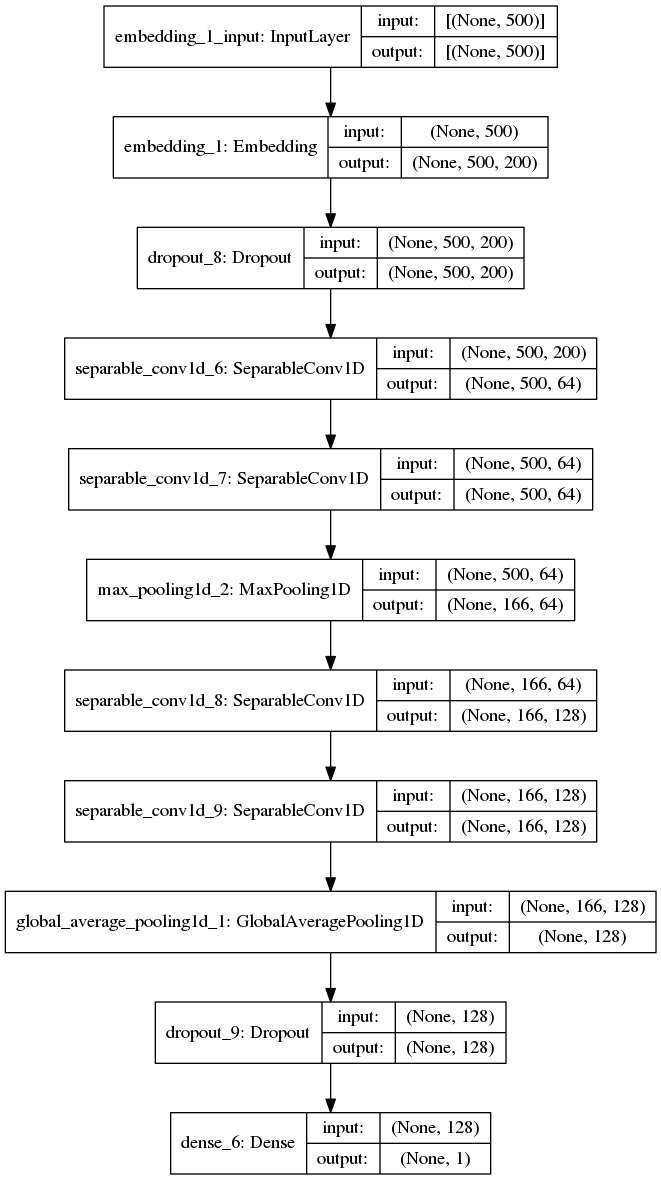

In [57]:
imdb_sepcnn_model = tf.keras.models.load_model("imdb_sepcnn_model.h5")

tf.keras.utils.plot_model(imdb_sepcnn_model, show_shapes=True)

### 模型调优

In [66]:
import argparse
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

import load_data
import train_ngram_model

In [67]:
def tune_ngram_model(data):
    """Tunes n-gram model on the given dataset.
    # Arguments
        data: tuples of training and test texts and labels.
    """
    # Select parameter values to try.
    num_layers = [1, 2, 3]
    num_units = [8, 16, 32, 64, 128]

    # Save parameter combination and results.
    params = {
        'layers': [],
        'units': [],
        'accuracy': [],
    }

    # Iterate over all parameter combinations.
    for layers in num_layers:
        for units in num_units:
                params['layers'].append(layers)
                params['units'].append(units)

                accuracy, _ = train_ngram_model.train_ngram_model(
                    data=data,
                    layers=layers,
                    units=units)
                print(('Accuracy: {accuracy}, Parameters: (layers={layers}, '
                       'units={units})').format(accuracy=accuracy,
                                                layers=layers,
                                                units=units))
                params['accuracy'].append(accuracy)
    _plot_parameters(params)


def _plot_parameters(params):
    """Creates a 3D surface plot of given parameters.
    # Arguments
        params: dict, contains layers, units and accuracy value combinations.
    """
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(params['layers'],
                    params['units'],
                    params['accuracy'],
                    cmap=cm.coolwarm,
                    antialiased=False)
    plt.savefig("tune_ngram_model.png")
    plt.show()

Train on 25000 samples, validate on 25000 samples
Epoch 1/1000
25000/25000 - 5s - loss: 0.6687 - acc: 0.8372 - val_loss: 0.6484 - val_acc: 0.8430
Epoch 2/1000
25000/25000 - 4s - loss: 0.6224 - acc: 0.8748 - val_loss: 0.6101 - val_acc: 0.8533
Epoch 3/1000
25000/25000 - 4s - loss: 0.5831 - acc: 0.8792 - val_loss: 0.5774 - val_acc: 0.8569
Epoch 4/1000
25000/25000 - 4s - loss: 0.5486 - acc: 0.8831 - val_loss: 0.5491 - val_acc: 0.8595
Epoch 5/1000
25000/25000 - 5s - loss: 0.5186 - acc: 0.8866 - val_loss: 0.5243 - val_acc: 0.8616
Epoch 6/1000
25000/25000 - 5s - loss: 0.4931 - acc: 0.8870 - val_loss: 0.5027 - val_acc: 0.8648
Epoch 7/1000
25000/25000 - 4s - loss: 0.4704 - acc: 0.8907 - val_loss: 0.4837 - val_acc: 0.8669
Epoch 8/1000
25000/25000 - 4s - loss: 0.4501 - acc: 0.8918 - val_loss: 0.4669 - val_acc: 0.8677
Epoch 9/1000
25000/25000 - 4s - loss: 0.4320 - acc: 0.8951 - val_loss: 0.4518 - val_acc: 0.8704
Epoch 10/1000
25000/25000 - 4s - loss: 0.4158 - acc: 0.8980 - val_loss: 0.4382 - val_a

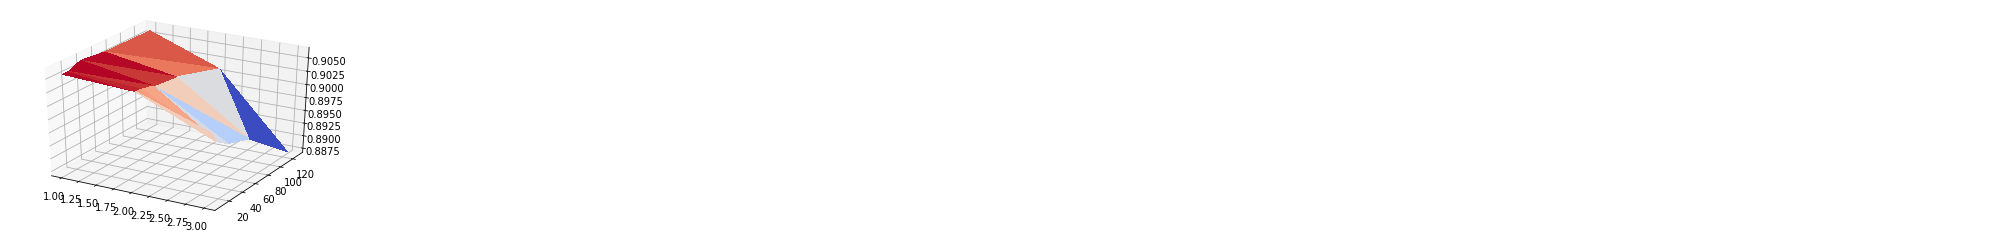

In [69]:
# Using the IMDb movie reviews dataset to demonstrate training n-gram model
data = load_data.load_imdb_sentiment_analysis_dataset(".")
tune_ngram_model(data)